<a href="https://colab.research.google.com/github/anujatayal/Colab-Notebooks/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.datasets import cifar10
from keras.utils import normalize, to_categorical

In [ ]:
!pip install -U git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ctrm_q7s
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ctrm_q7s
  Created wheel for tensorflow-examples: filename=tensorflow_examples-d94c954859a7e3326201f4fd43587cd172eab63d_-cp36-none-any.whl size=137929 sha256=6ee8542cb73b520ca9c35acb2deac0e3b489d557c792121852d2b761d54eae08
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ymsoskv/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
  Found existing installation: tensorflow-examples d94c954859a7e3326201f4fd43587cd172eab63d-
    Uninstalling tensorflow-examples-d94c954859a7e3326201f4fd43587cd172eab63d-:
      Successfully uninstalled tensorflow-examples-d94c954859a7e3326201f4fd43587cd172eab63d-


In [ ]:
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt



In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:*.*.*', with_info=True)

NonMatchingChecksumError: ignored

In [ ]:
def getBB(file):
  
  #parse the annotations
  path = f'annotations/xmls/{file}'
  tree = ET.parse(path)
  root = tree.getroot()
  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text

  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text

  return((int(xmin), int(ymin)), (int(xmax), int(ymax)))

def drawBB(file):
  #draw the bounding box
  img_path = f'images/{file[:-4]}.jpg'
  img = cv2.imread(img_path)
  
  (xmin, ymin), (xmax, ymax) = getBB(file)

  print(getBB(file))
  annotated = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  
  plt.imshow(annotated[:,:,::-1])
  plt.axis('off')
  plt.show()

((28, 64), (72, 118))


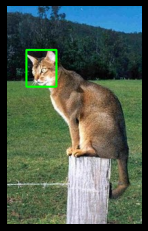

In [ ]:
file = np.random.choice(os.listdir('annotations/xmls/'))
drawBB(file)

In [ ]:
import cv2
import xml.etree.ElementTree as ET


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [ ]:
ls

annotations/  annotations.tar.gz  images/  images.tar.gz  sample_data/


In [ ]:
import tensorflow_datasets as tfds

ds, ds_info = tfds.load("celeb_a", with_info = True)
print(ds_info)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

KeyboardInterrupt: ignored